In [1]:
# Imports packages needed and pipeline functionalities
from utils import *
import ms3

# Aligning audio to annotated score labels

## Intro
This notebook drives you to a detailed understanding of the aligning pipeline. It allows you to see the behaviour of the pipeline's steps independently, visualize some steps, and shows how the pipeline could be adapted to data outside the *Annotated Mozart Sonatas* dataset, for which the user interface is currently designed.

### Preparing the dataset

First, download the [Annotated Mozart Sonatas corpus](https://github.com/DCMLab/mozart_piano_sonatas/tree/update) (from the *update* branch).

Second, install the [`ms3` parser](https://github.com/johentsch/ms3), navigate to the top level of the *mozart_piano_sonatas* repository and generate the notes and labels files
needed for audio-to-annotation alignment by running:

`python ms3 extract -N [folder_to_write_notes_file_to] -X [folder_to_write_labels_file_to] -q`

This will provide additional quarterbeats information needed for alignment.

### Identifying the data needed

*Note:* For the purpose of this notebook, you can just as well use the selected files of piece *K309-2* provided in the `examples` folder.

The Annotated Mozart Sonatas corpus contains files of interest for the pipeline in the `notes` and `harmonies` (that contain labels) folders. Every piece of the corpus contains a corresponding TSV file in these folders. You can identify them and pass them in the variables `notes_path` and `label_path` below.

In [2]:
# Define paths to notes and harmonies files

notes_path = "examples/K309-2_notes.tsv"
labels_path = "examples/K309-2_labels.tsv"

Have a look at the files content:

In [3]:
notes_df = ms3.load_tsv(notes_path)
labels_df = ms3.load_tsv(labels_path)

pd.set_option('display.max_columns', None)
notes_df.head(3)

,quarterbeats,duration_qb,mc,mn,mc_onset,mn_onset,timesig,staff,voice,duration,gracenote,nominal_duration,scalar,tied,tpc,midi,chord_id
0,0,0.375,1,1,0,0,3/4,1,1,3/32,NaN,1/16,3/2,<NA>,3,69,0
1,3/8,0.125,1,1,3/32,3/32,3/4,1,1,1/32,NaN,1/32,1,<NA>,-1,65,1
2,1/2,0.375,1,1,1/8,1/8,3/4,1,1,3/32,NaN,1/16,3/2,<NA>,-2,70,2


In [4]:
labels_df.head(3)

,quarterbeats,duration_qb,mc,mn,mc_onset,mn_onset,timesig,staff,voice,label,globalkey,localkey,pedal,chord,numeral,form,figbass,changes,relativeroot,cadence,phraseend,chord_type,globalkey_is_minor,localkey_is_minor,chord_tones,added_tones,root,bass_note
0,0,0.5,1,1,0,0,3/4,2,1,F.I{,F,I,NaN,I,I,NaN,NaN,NaN,NaN,NaN,{,M,False,False,"(0, 4, 1)",(),0,0
1,1/2,0.5,1,1,1/8,1/8,3/4,2,1,viio6,F,I,NaN,viio6,vii,o,6,NaN,NaN,NaN,NaN,o,False,False,"(2, -1, 5)",(),5,2
2,1,2.0,1,1,1/4,1/4,3/4,2,1,I,F,I,NaN,I,I,NaN,NaN,NaN,NaN,NaN,NaN,M,False,False,"(0, 4, 1)",(),0,0


### Loading an audio file

At this step, you need to provide yourself an audio recording of your choice of the K309 sonata, movement 2, in WAV format.

In [5]:
# Define path to the audio
audio_path = "examples/K309-2_audio.wav"
audio, _ = librosa.load(audio_path, sr=Fs)

### Feature extraction

The DTW and feature processing steps follow the audio-to-score alignement tutorial from *SyncToolBox*. Refer to their notebook and to the FMP notebooks they refer to for more details. 

## Perform audio-to-labels alignment

In the next cells, we will proceed to the audio-to-labels alignment step by step, as is being done when the command line interface is used.

### Synthesizing the notes symbolic sequence into an object comparable to audio

One of the main contributions of this alignment pipeline was to adapt the way the score information is fed to the synchronization steps. Whereas *SyncToolBox* proposes to take the score in XML file and convert it to a `music21` object, a conversion that is prone to information loss and that does not allow for keeping track of the labels we are interested in and their positions, a workaround is to transform the *notes* file directly into the object the synchronization algorithm needs, i.e. a dataframe containing the following columns for each note event:

- `start`: timestamp of the note event. Obtained from the `quarterbeats` column.
- `duration`: duration of the note event. Obtained from the `duration_qb` column.
- `pitch`: pitch of the note event. Obtained from the `midi` column.
- `velocity`: artificially infered to 1
- `instrument`: artificially infered to 'piano'

This way, the *notes* file is synthesized into an object like could have been obtained from an MIDI file and that can be compared to an audio sequence and considered as such to extract relevant features for synchronization.


In [6]:
# Synthesize notes
df_annotation = corpus_to_df_musical_time(notes_path)
df_annotation.head(3)

,start,duration,pitch,end,velocity,instrument
0,1.000,0.375,69,1.375,1.0,piano
1,1.375,0.125,65,1.500,1.0,piano
2,1.500,0.375,70,1.875,1.0,piano


We still need to keep track of the link between notes and labels so that we can align labels to the temporally aligned notes after synchronization. This can be done knowing that both *notes* and *labels* contain a similar running index, i.e. quarterbeats. We thus join both dataframes based on this index in an outer join fashion into an extended dataframe that we will use later in the pipeline.

In [7]:
# Keep track of notes annotations and labels correspondances
df_annotation_extended = align_corpus_notes_and_labels(notes_path, labels_path)
df_annotation_extended.head(3)

,quarterbeats,duration_qb,mc,mn,mc_onset,mn_onset,timesig,staff,voice,duration,gracenote,nominal_duration,scalar,tied,tpc,midi,chord_id,label,globalkey,localkey,pedal,chord,numeral,form,figbass,changes,relativeroot,cadence,phraseend,chord_type,globalkey_is_minor,localkey_is_minor,chord_tones,added_tones,root,bass_note
0,0,0.375,1,1,0,0,3/4,1,1,3/32,NaN,1/16,3/2,<NA>,3,69,0,F.I{,F,I,NaN,I,I,NaN,NaN,NaN,NaN,NaN,{,M,False,False,"(0, 4, 1)",(),0,0
1,3/8,0.125,1,1,3/32,3/32,3/4,1,1,1/32,NaN,1/32,1,<NA>,-1,65,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
2,1/2,0.375,1,1,1/8,1/8,3/4,1,1,3/32,NaN,1/16,3/2,<NA>,-2,70,2,viio6,F,I,NaN,viio6,vii,o,6,NaN,NaN,NaN,NaN,o,False,False,"(2, -1, 5)",(),5,2


#### Tuning estimation

In [8]:
# Estimate tuning deviation
tuning_offset = estimate_tuning(audio, Fs)
print('Estimated tuning deviation for recording: %d cents' % (tuning_offset))

Estimated tuning deviation for recording: 6 cents


#### Features from audio

The next cell computes audio feature extraction needed for DTW, i.e. chroma onset (CO) extraction, locally adaptive normalization and addition of temporal decay, resulting in two different features vectors: quantized chroma features and decaying locally adaptive normalized CO features (DLCNO).

Below the respective feature computation steps appear, i.e. in appearing order:
- pitch features
- quantized chroma features: chromagram showing aggreagation into chroma bands
- pitch onset features
- aggration into chroma onset features representation
- spectograms showing the local amplitude of chroma onset features
- chromagrams after normalization by local norms of chroma onset features (LNCO)
- chromagrams after adding decay (DLNCO)

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


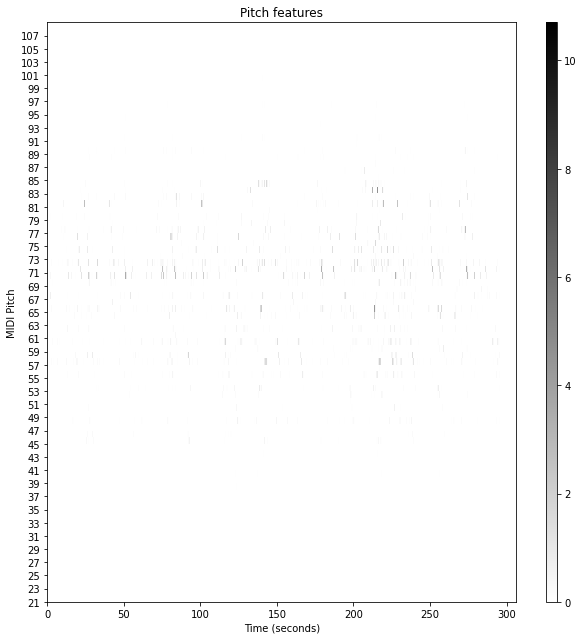

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


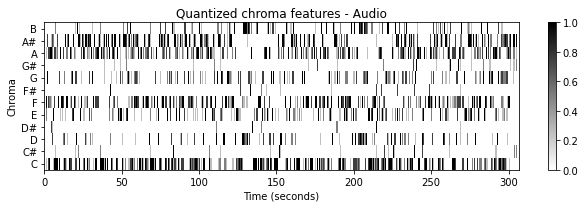

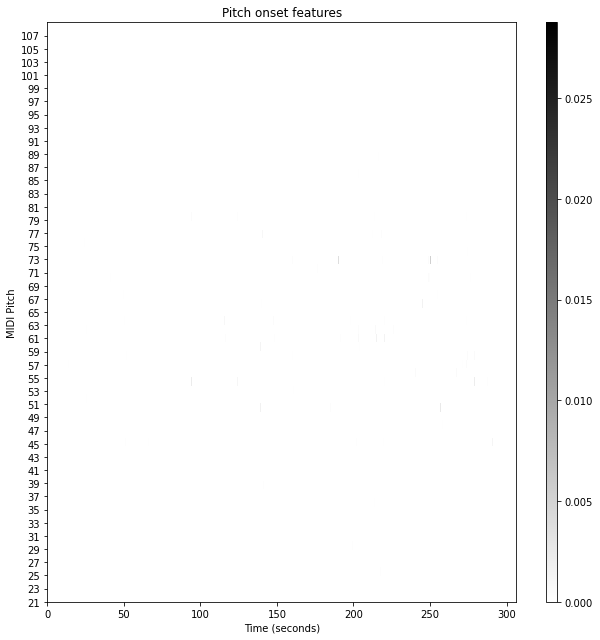

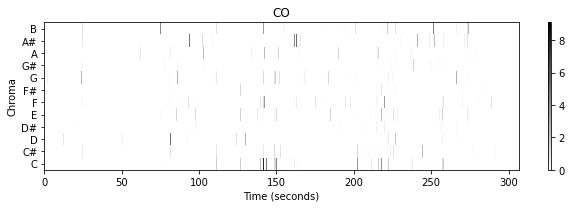

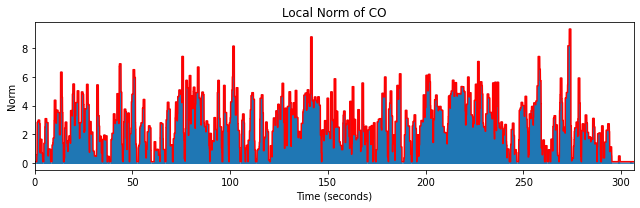

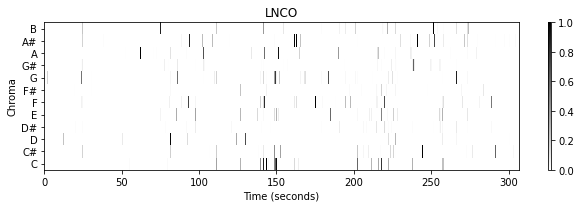

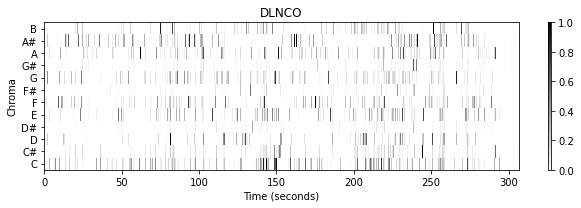

In [9]:
# Compute features from audio
# Note: skip the visualization part by setting visualize to False
f_chroma_quantized_audio, f_DLNCO_audio = get_features_from_audio(audio, tuning_offset, Fs, feature_rate, visualize=True)

#### Features from annotations

The next cell computes similar feature extraction needed for DTW from annotations.

*Note*: since in our approach we artifially infered the velocity, the local norm of CO features is equal to the value we assigned the velocity to (i.e, 1), but this step is still kept in case the annotations provided (e.g. a MIDI file) contain it.

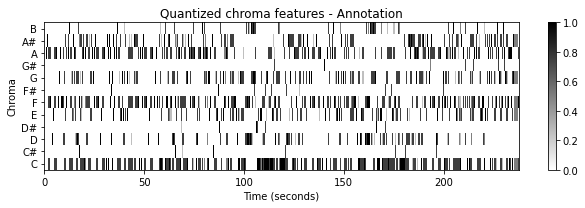

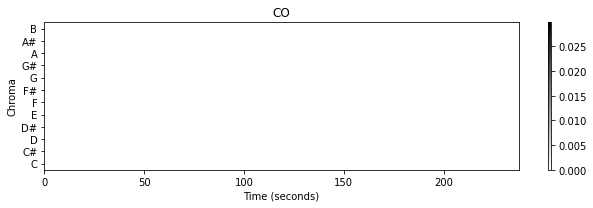

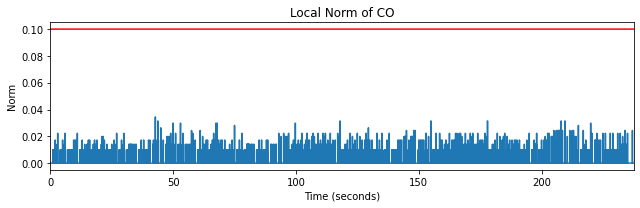

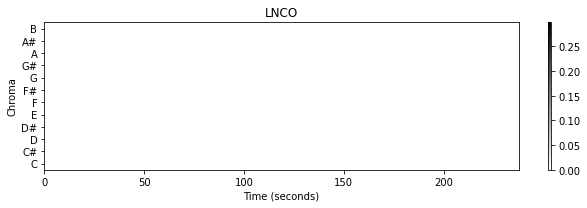

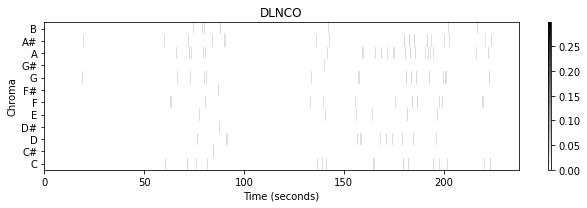

In [10]:
# Compute features from annotations
f_chroma_quantized_annotation, f_DLNCO_annotation = get_features_from_annotation(df_annotation, feature_rate, visualize=True)

### Additional pre-processing

A last step before syncrhonizing feature sequences requires to adjust their chroma range together. In this purpose the optimal chroma shift between both is computed, and is then substrated to the features extracted from annotations.

If audio chroma match those of annotations, the chroma shift found is 0.

In [11]:
# Calculate chroma shift between audio and annotations
f_cens_1hz_audio = quantized_chroma_to_CENS(f_chroma_quantized_audio, 201, 50, feature_rate)[0]
f_cens_1hz_annotation = quantized_chroma_to_CENS(f_chroma_quantized_annotation, 201, 50, feature_rate)[0]
opt_chroma_shift = compute_optimal_chroma_shift(f_cens_1hz_audio, f_cens_1hz_annotation)

print('Pitch shift between the audio recording and score, determined by DTW:', opt_chroma_shift, 'bins')

# Apply potential shift to audio and annotations features
f_chroma_quantized_annotation = shift_chroma_vectors(f_chroma_quantized_annotation, opt_chroma_shift)
f_DLNCO_annotation = shift_chroma_vectors(f_DLNCO_annotation, opt_chroma_shift)

Pitch shift between the audio recording and score, determined by DTW: 0 bins


### Synchronization: applying DTW to compute the warping path

The synchronization is performed by the following steps:
1. Find the warping path between both *notes* sequences. This is achieved by computing a similartiy matrix between each pair of both sequences features, and then finding the path that minimizes the distance cost between them.
2. Make the warping path monotonic, to ensure every note from the annotations finds one and only synchronized match in the audio sequence.
3. Align annotations *notes* with their matched audio notes events that give the corresponding time positions.

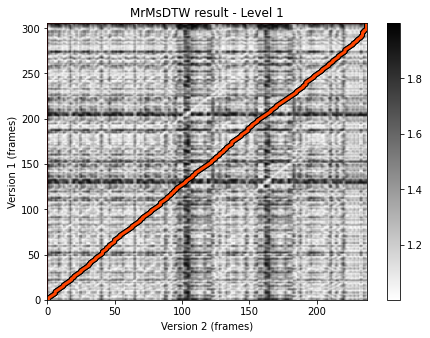

Level 0 computation time: 0.06 seconds


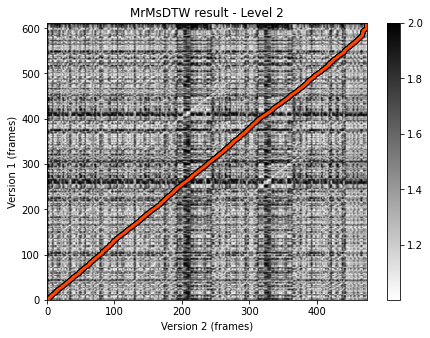

Level 1 computation time: 0.26 seconds


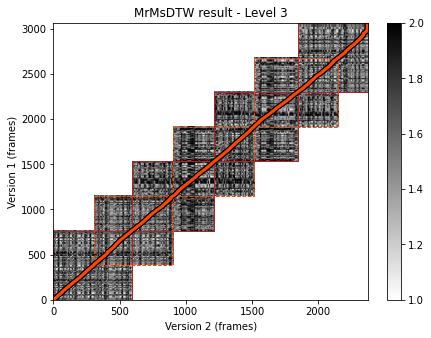

Level 2 computation time: 0.25 seconds


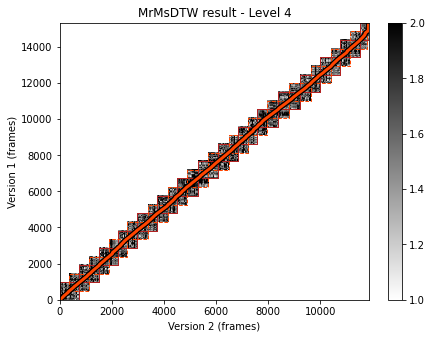

Level 3 computation time: 1.44 seconds
Computation time of MrMsDTW: 2.01 seconds


In [12]:
# Compute warping path
wp = sync_via_mrmsdtw(f_chroma1=f_chroma_quantized_audio, 
                    #f_onset1=f_DLNCO_audio, 
                    f_chroma2=f_chroma_quantized_annotation, 
                    #f_onset2=f_DLNCO_annotation, 
                    input_feature_rate=feature_rate, 
                    step_weights=step_weights, 
                    threshold_rec=threshold_rec, 
                    verbose=True)

# Make warping path monotonic
wp = make_path_strictly_monotonic(wp)

# Use warping path to align annotations to real timestamps 
df_annotation_warped = warp_annotations(df_annotation, wp, feature_rate)

### Score following

In case you are interested in score following applications, you can also simply store the notes and visualise them live, as a MIDI. You can find out more in the *Applications* section.

### Align labels

At this point, the dataframe obtained simply gives notes and their temporal positions (respectively in the `pitch` and `start` column).

In [13]:
df_annotation_warped.head(3)

,start,duration,pitch,end,velocity,instrument
0,1.100,0.425,69,1.525,1.0,piano
1,1.525,0.155,65,1.680,1.0,piano
2,1.680,0.510,70,2.190,1.0,piano


This is the point where you can design your own alignment approach, depending on the data you provided.

Using the Annotated Mozart Sonatas, you can follow the procedure below.

*Note:* you can use the paramter `mode` to choose to output temporal positions of either:
- only labels (`compact`),
- labels with their additional details as present in the dataset (`labels`),
- merged notes and labels datasets with additional information (`extended`)

In [14]:
# Align time-aligned annotations of notes with labels
result = align_warped_notes_labels(df_annotation_warped, df_annotation_extended, mode = "compact")
result.head()

,timestamp,label
0,1.10,F.I{
2,1.68,viio6
4,2.40,I
12,5.16,IV
14,5.78,V


### Evaluation

In case you wish to compare the result of synchronization with groundtruth aligned positions, you can evaluate the alignment's accuracy with SyncToolBox's evaluation functionality. Below is a toy example of its use.

In [15]:
# Create toy comparison
from synctoolbox.dtw.utils import evaluate_synchronized_positions
import numpy as np

toy_comparison = result.copy()
toy_comparison['timestamp'] = toy_comparison['timestamp'] + np.random.normal(0, 0.1, len(toy_comparison))

# Input result and comparison here:
mean_absolute_error, accuracy_at_tolerances = evaluate_synchronized_positions(result['timestamp']*1000, toy_comparison['timestamp']*1000)

Measure transfer from recording 1 to 2 yielded:

Mean absolute error (MAE): 79.51ms (standard deviation: 53.92ms)

Accuracy of transferred positions at different tolerances:
			Accuracy
################################
Tolerance: 10 ms 	6.56 %
Tolerance: 20 ms 	12.74 %
Tolerance: 30 ms 	20.46 %
Tolerance: 40 ms 	28.96 %
Tolerance: 50 ms 	36.29 %
Tolerance: 60 ms 	40.15 %
Tolerance: 70 ms 	47.88 %
Tolerance: 80 ms 	53.67 %
Tolerance: 90 ms 	61.78 %
Tolerance: 100 ms 	69.50 %
Tolerance: 150 ms 	88.42 %
Tolerance: 250 ms 	99.61 %


## Applications

Finally, you can store the output and visualize the result live with SonicVisualiser for example, as explained on the tutorial [here](https://github.com/clelf/Aligning-audio-to-annotated-score-labels/blob/DTW/README.md).